In [ ]:
pip install sentence-transformers

In [ ]:
pip install transformers


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sentence_transformers import evaluation
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses
from torch.utils.data import DataLoader
from sentence_transformers import evaluation
from scipy.stats import pearsonr


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path='/content/drive/MyDrive/NLPassign3/A3_task1_data_files/train.csv'

In [ ]:
scores=[]
input_sentenses1=[]
input_sentenses2=[]
import csv
with open(file_path, 'r', newline='') as csvfile:
    csvFil = csv.reader(csvfile)
    for lines in csvFil:
        arr=lines[0].split('\t')
        if(len(arr)==3):

          try:
            scores.append(float(arr[0]))
          except:
            print(arr[0])
          input_sentenses1.append(arr[1])
          input_sentenses2.append(arr[2])

score


In [ ]:
scores=scores
input_sentenses1=input_sentenses1[1:]
input_sentenses2=input_sentenses2[1:]

In [ ]:
len(input_sentenses1)

4743

In [ ]:
inputsentense=[]
for i in range(len(input_sentenses1)):
  inputsentense.append(input_sentenses1[i]+' [SEP] ' +input_sentenses2[i])

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_bert_embeddings(input_text):
    tokens = tokenizer.encode_plus(input_text, add_special_tokens=True, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**tokens)
        # print(outputs)
    # embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze(0)
    embeddings = outputs[0]
    return embeddings.numpy()

In [ ]:
import numpy as np
embeddings_file = '/content/drive/MyDrive/NLPassign3/A3_task1_data_files/embeddings.npz'

# sentence1_embedding=[get_bert_embeddings(sentence) for sentence in input_sentenses1]
# sentence2_embedding=[get_bert_embeddings(sentence) for sentence in input_sentenses2]
# np.savez(embeddings_file, embeddings_1=sentence1_embedding, embeddings_2=sentence2_embedding)



In [ ]:
embeddings_npz = np.load(embeddings_file)
sentence1_embedding = embeddings_npz['embeddings_1']
sentence2_embedding = embeddings_npz['embeddings_2']
print("Embeddings loaded from file.")

Embeddings loaded from file.


In [ ]:
validscores=[]
valid_sentenses1=[]
valid_sentenses2=[]
devpath="/content/drive/MyDrive/NLPassign3/A3_task1_data_files/dev.csv"
with open(devpath, 'r', newline='') as csvfile:
    csvFil = csv.reader(csvfile)
    for lines in csvFil:
        arr=lines[0].split('\t')
        if(len(arr)==3):

          try:
            validscores.append(float(arr[0]))
          except:
            print(arr[0])
          valid_sentenses1.append(arr[1])
          valid_sentenses2.append(arr[2])


valid_sentenses1=valid_sentenses1[1:]
valid_sentenses2=valid_sentenses2[1:]

score


In [ ]:
X = [torch.cat([torch.tensor(sentence1_embedding[i]).reshape(-1), torch.tensor(sentence2_embedding[i]).reshape(-1)]) for i in range(len(sentence1_embedding))]

valid1_embedding=[get_bert_embeddings(sentence) for sentence in valid_sentenses1]
valid2_embedding=[get_bert_embeddings(sentence) for sentence in valid_sentenses2]
X_valid = [torch.cat([torch.tensor(valid1_embedding[i]).reshape(-1), torch.tensor(valid2_embedding[i]).reshape(-1)]) for i in range(len(valid1_embedding))]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

Linearmodel = LinearModel(X[0].shape[0])


In [ ]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Linearmodel.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.01,
                                                 patience=1)

In [ ]:
print(X[0].shape[0])

4


In [ ]:

from tqdm import tqdm_notebook
import time
num_epochs = 1000

traning_loss=[]
validation_loss=[]
epoch_bar=tqdm_notebook(desc='training routine',
                          total=num_epochs,
                        position=0)
for epoch in range(num_epochs):
    Linearmodel.train()
    optimizer.zero_grad()
    outputs = Linearmodel(torch.stack(X))
    loss = loss_function(outputs.squeeze(), torch.tensor(scores, dtype=torch.float))
    loss.backward()
    optimizer.step()
    epoch_bar.update()
    traning_loss.append(loss.item())


    # Linearmodel.eval()
    with torch.no_grad():
        outputs = Linearmodel(torch.stack(X_valid))
        # predictions = outputs.squeeze().numpy()
        loss_v = loss_function(outputs.squeeze(), torch.tensor(validscores, dtype=torch.float))
        validation_loss.append(loss_v.item())

Linearmodel.eval()
with torch.no_grad():
    outputs = Linearmodel(torch.stack(X_valid))
    predictions = outputs.squeeze().numpy()

mse = mean_squared_error(validscores, predictions)
print("Mean Squared Error:", mse)

<ipython-input-31-e22dcad13d98>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epoch_bar=tqdm_notebook(desc='training routine',


training routine:   0%|          | 0/1000 [00:00<?, ?it/s]

Mean Squared Error: 6.670232002013039


In [ ]:
model_path_linear = '/content/drive/MyDrive/NLPassign3/A3_task1_data_files/linearmodel'

# Save the trained model
torch.save(Linearmodel.state_dict(), model_path_linear)

In [ ]:
import matplotlib.pyplot as plt

def plot_array(arr,title):
    """
    Plots an array of numbers.

    Parameters:
        arr (list or numpy.ndarray): Array of numbers to be plotted.
    """
    plt.plot(arr)
    plt.xlabel('epoches')
    plt.ylabel('loss')
    plt.title(f'Loss plot ({title})')
    # plt.grid(True)
    plt.show()

In [ ]:
traning_loss[1]

6.436137676239014

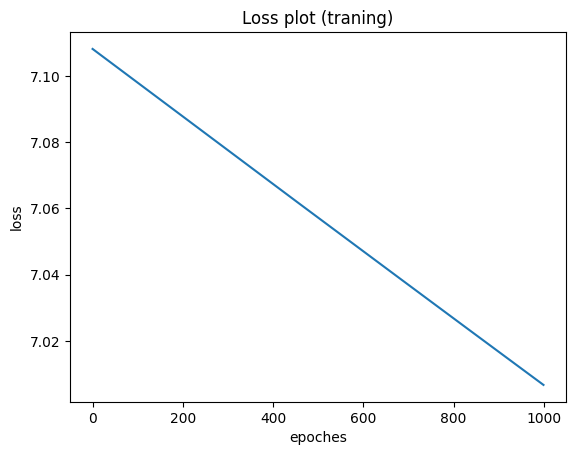

In [ ]:
plot_array(traning_loss,'traning')

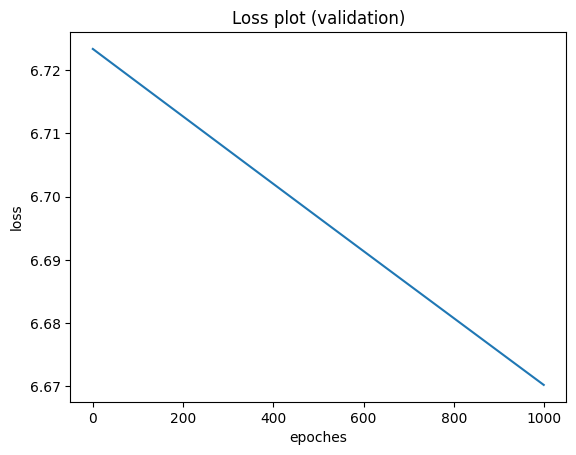

In [ ]:
plot_array(validation_loss,'validation')

In [ ]:
Linearmodel.eval()
with torch.no_grad():
    outputs = Linearmodel(torch.stack(X_valid))
    predictions = outputs.squeeze().numpy()

mse = mean_squared_error(validscores, predictions)
print("Mean Squared Error:", mse)
pearson_corr = pearsonr(validscores, predictions)
print("Pearson correlation coefficient:", pearson_corr)

Mean Squared Error: 6.670232002013039
Pearson correlation coefficient: PearsonRResult(statistic=-0.004698806826333413, pvalue=0.8772508708681003)


In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name,num_labels=1)
tokens = tokenizer.encode_plus(inputsentense[0], add_special_tokens=True, return_tensors='pt')
with torch.no_grad():
    outputs = model(**tokens,)
    # print(outputs)
# embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze(0)
embeddings = outputs[0]
print(embeddings)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[-0.3255]])


In [ ]:
# np.savez("/content/drive/MyDrive/NLPassign3/A3_task1_data_files/embeddings1.npz", embeddings_1=inputseq)
# inputseq=[[get_bert_embeddings(sentence) for sentence in inputsentense]]
inputseq=[]
# train_inputids=[]

for i in inputsentense:
  tokens = tokenizer.encode_plus(i, add_special_tokens=True, return_tensors='pt')
  inputseq.append(tokens)

# inputseq[0]


In [ ]:
validsenten=[]
for i in range(len(valid_sentenses1)):
  validsenten.append(valid_sentenses1[i]+' [SEP] '+valid_sentenses2[i])

# vads=[[get_bert_embeddings(sentence) for sentence in validsenten]]
vads=[]
for i in validsenten:
  tokens = tokenizer.encode_plus(i, add_special_tokens=True, return_tensors='pt')
  vads.append(tokens)

In [ ]:
# https://discuss.huggingface.co/t/finetune-pretrained-bert-for-custom-regression-task/18562/4
from transformers import PreTrainedModel, AutoModel
class BertSimilarity(PreTrainedModel):
    def __init__(self,config):
        super().__init__(config)
        self.bert = AutoModel.from_config(config)
        self.linear = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, x):
        arr=[]
        for i in x:
          out=self.bert(**i)
          arr.append(out.last_hidden_state)
        # pooled_output = outputs[1]
        # sequence_output = outputs.last_hidden_state
        output = self.linear(arr)
        return output


    # def __init__(self,bertmodel):
    #     # super(BertForRegression, self).__init__()

    #     # Change the output layer for regression
    #     self.regressor = nn.Linear(config.hidden_size, 1)
    #     self.config = config

    # def forward(self, input_ids, attention_mask=None, token_type_ids=None):
    #     outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    #     pooled_output = outputs[1]  # Use the pooled output
    #     output = self.regressor(pooled_output)
    #     return output
config = BertForSequenceClassification.config_class.from_pretrained('bert-base-uncased')
similarity_model=BertSimilarity(config).to(device)

In [ ]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(similarity_model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

In [ ]:
inputseq

array([-0.3962843 , -0.35540894, -0.3693592 , ..., -0.32860368,
       -0.28649068, -0.38092357], dtype=float32)

In [ ]:

from tqdm import tqdm_notebook
import time
num_epochs = 3

traning_loss=[]
validation_loss=[]
epoch_bar=tqdm_notebook(desc='training routine',
                          total=num_epochs,
                        position=0)
for epoch in range(num_epochs):
    similarity_model.train()
    optimizer.zero_grad()
    outputs = similarity_model(inputseq)
    loss = loss_function(outputs.squeeze(), torch.tensor(scores, dtype=torch.float))
    loss.backward()
    optimizer.step()
    epoch_bar.update()
    traning_loss.append(loss.item())


    # Linearmodel.eval()
    with torch.no_grad():
        outputs = similarity_model(vads)
        # predictions = outputs.squeeze().numpy()
        loss_v = loss_function(outputs.squeeze(), torch.tensor(validscores, dtype=torch.float))
        validation_loss.append(loss_v.item())

# similarity_model.eval()
# with torch.no_grad():
#     outputs = similarity_model(torch.stack(torch.tensor(vads)))
#     predictions = outputs.squeeze().numpy()

# mse = mean_squared_error(validscores, predictions)
# print("Mean Squared Error:", mse)

<ipython-input-17-b5344eadcd65>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epoch_bar=tqdm_notebook(desc='training routine',


training routine:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
similarity_model.eval()
with torch.no_grad():
    outputs = similarity_model(torch.stack(vads))
    predictions = outputs.squeeze().numpy()

mse = mean_squared_error(validscores, predictions)
print("Mean Squared Error:", mse)
pearson_corr = pearsonr(validscores, predictions)
print("Pearson correlation coefficient:", pearson_corr)

Cosine similarity

In [ ]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
model_name = 'stsb-roberta-large'
model = SentenceTransformer(model_name)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
embeddings_1 = model.encode(valid_sentenses1, convert_to_tensor=True)
embeddings_2 = model.encode(valid_sentenses2, convert_to_tensor=True)


In [ ]:
cosine_similarities = util.pytorch_cos_sim(embeddings_1, embeddings_2).cpu().numpy()


In [ ]:
cosine_similarities.shape

(1083, 1083)

In [ ]:
len(validscores)

1083

In [ ]:
diagonal_similarity = np.diag(cosine_similarities)
t_sorre=[i/5 for i in validscores]
mse = mean_squared_error(t_sorre, diagonal_similarity)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.03526313110188672


In [ ]:
pearson_corr = pearsonr(t_sorre, diagonal_similarity)
print("Pearson correlation coefficient:", pearson_corr)

Pearson correlation coefficient: PearsonRResult(statistic=0.8155824666904162, pvalue=4.339986148814607e-259)


#fine tune model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.utils.data.dataloader import default_collate
from sentence_transformers.readers import InputExample

def custom_collate(batch):

    if isinstance(batch[0], InputExample):
        # Extract features from InputExample objects
        features = [(example.texts[0],example.texts[0],example.label) for example in batch]
        return features
    else:
        # Use default collate for other data types
        return default_collate(batch)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# class SimilarityDataset(Dataset):
#     def __init__(self, sentence1_embedding, sentence2_embedding, similarity_scores):
#         self.sentence1_embedding = sentence1_embedding
#         self.sentence2_embedding = sentence2_embedding
#         self.similarity_scores = similarity_scores

#     def __len__(self):
#         return len(self.sentence1_embedding)

#     def __getitem__(self, idx):
#         sentence_1 = self.sentence1_embedding[idx]
#         sentence_2 = self.sentence2_embedding[idx]
#         similarity_score = self.similarity_scores[idx]

#         return sentence_1, sentence_2, self.similarity_scores[idx]



# make a dataset
def makdataset(sentense1,sentense2,label):
  arr=[]
  for i in range(len(sentense1)):
    arr.append(InputExample(texts=[sentense1[i],sentense2[i]], label=(label[i])/5))
    # arr.append((sentense1[i],sentense2[i], (label[i])/5))

  return arr



dataset = makdataset(input_sentenses1,input_sentenses2,scores)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True,collate_fn=custom_collate)




In [ ]:
validation_dataset=makdataset(valid_sentenses1,valid_sentenses2,validscores)

valid_dataloader= DataLoader(validation_dataset, batch_size=32, shuffle=True,collate_fn=custom_collate)


In [ ]:
model_name = 'stsb-roberta-large'
model1AC = SentenceTransformer(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
cosine_loss = losses.CosineSimilarityLoss(model1AC)


In [ ]:

estscoe=[i/5 for i in validscores]
evaluator = evaluation.EmbeddingSimilarityEvaluator(valid_sentenses1,valid_sentenses2,estscoe)


In [ ]:
num_epochs = 10
warmup_steps = int(len(dataloader) * num_epochs * 0.1)
train_loss=[]
valid_loss=[]
for i in range(num_epochs):
  embeddings_1_ac = model1AC.encode(input_sentenses1, convert_to_tensor=True)
  embeddings_2_ac = model1AC.encode(input_sentenses2, convert_to_tensor=True)
  cosine_similarities = util.pytorch_cos_sim(embeddings_1_ac, embeddings_2_ac).cpu().numpy()

  # print("Cosine Similarity:", cosine_similarity.item())
  diagonal_similarity = np.diag(cosine_similarities)
  t_sorre=[i/5 for i in scores]
  mse = mean_squared_error(t_sorre, diagonal_similarity)
  print("Mean Squared Error:", mse)
  train_loss.append(mse)
  model1AC.fit(train_objectives=[(dataloader, cosine_loss)],
          evaluator=evaluator,
          epochs=1,
          evaluation_steps=5000,
          warmup_steps=warmup_steps,
          output_path='fine_tuned_model')

  embeddings_1_ac = model1AC.encode(valid_sentenses1, convert_to_tensor=True)
  embeddings_2_ac = model1AC.encode(valid_sentenses2, convert_to_tensor=True)
  cosine_similarities = util.pytorch_cos_sim(embeddings_1_ac, embeddings_2_ac).cpu().numpy()

  # print("Cosine Similarity:", cosine_similarity.item())
  diagonal_similarity = np.diag(cosine_similarities)
  t_sorre=[i/5 for i in validscores]
  mse = mean_squared_error(t_sorre, diagonal_similarity)
  print("Mean Squared Error:", mse)
  valid_loss.append(mse)


Mean Squared Error: 0.005348553511812123


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/149 [00:00<?, ?it/s]

Mean Squared Error: 0.03259707381363163
Mean Squared Error: 0.005159476257624344


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/149 [00:00<?, ?it/s]

Mean Squared Error: 0.03192030724157192
Mean Squared Error: 0.0048227472648521555


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/149 [00:00<?, ?it/s]

Mean Squared Error: 0.033246915532701454
Mean Squared Error: 0.004242258221259098


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/149 [00:00<?, ?it/s]

Mean Squared Error: 0.032957503172903836
Mean Squared Error: 0.0044196196069860305


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/149 [00:00<?, ?it/s]

Mean Squared Error: 0.03163219739648429
Mean Squared Error: 0.00439001060400989


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/149 [00:00<?, ?it/s]

Mean Squared Error: 0.032384527102756924
Mean Squared Error: 0.004390437737095475


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/149 [00:00<?, ?it/s]

Mean Squared Error: 0.0319004566013568
Mean Squared Error: 0.004195297625960782


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/149 [00:00<?, ?it/s]

Mean Squared Error: 0.03272825926904862
Mean Squared Error: 0.004474614330925588


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/149 [00:00<?, ?it/s]

Mean Squared Error: 0.032836033405149886
Mean Squared Error: 0.003645270852049557


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/149 [00:00<?, ?it/s]

Mean Squared Error: 0.03248952599724116


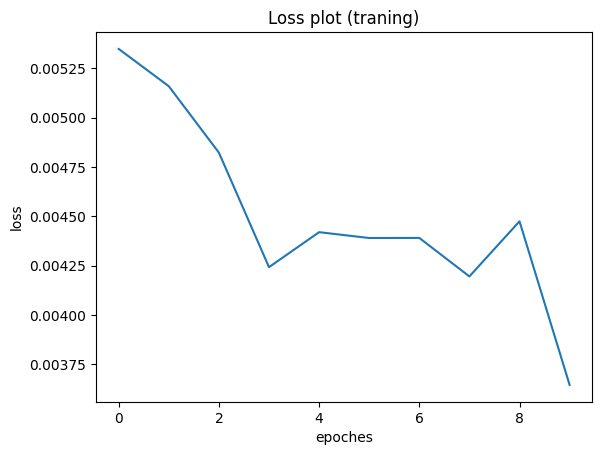

In [ ]:
plot_array(train_loss,'traning')

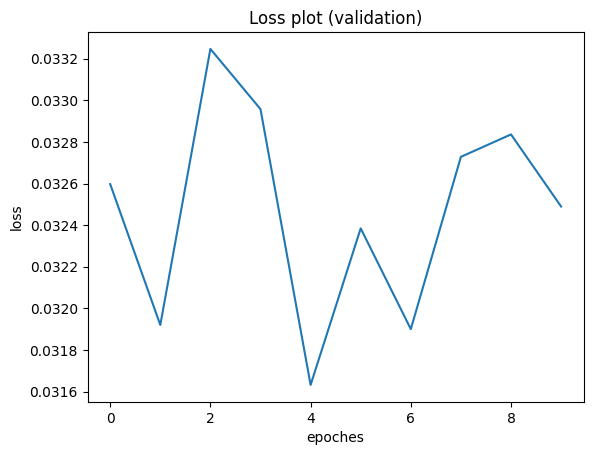

In [ ]:
plot_array(valid_loss,'validation')

In [ ]:
model_path="/content/drive/MyDrive/NLPassign3/model1AC_10epoch"
model1AC.save(model_path)

In [ ]:
evaluation_result = evaluator(model1AC, output_path='fine_tuned_model')
print("Performance on the validation set:", evaluation_result)

Performance on the validation set: 0.8297168704058623


In [ ]:
diagonal_similarity = np.diag(cosine_similarities)
t_sorre=[i/5 for i in validscores]
mse = mean_squared_error(t_sorre, diagonal_similarity)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.03248952599724116


In [ ]:
pearson_corr = pearsonr(t_sorre, diagonal_similarity)
print("Pearson correlation coefficient:", pearson_corr)

Pearson correlation coefficient: PearsonRResult(statistic=0.8303416793059837, pvalue=8.902318663885784e-277)


**code for test**


In [ ]:
file_path="/content/drive/MyDrive/NLPassign3/A3_task1_data_files/sample_test.csv"

In [ ]:
ids=[]
test_sentenses1=[]
test_sentenses2=[]
zp=0
with open(file_path, 'r', newline='') as csvfile:
    csvFil = csv.reader(csvfile)
    for lines in csvFil:
        if zp==0:
          zp=1
          continue
        arr=lines[0].split('\t')
        ids.append(arr[0])
        test_sentenses1.append(arr[1])
        test_sentenses2.append(arr[2])






**load the model**

In [ ]:
model_path="/content/drive/MyDrive/NLPassign3/model1AC_10epoch"
model1AC=SentenceTransformer(model_path)

In [ ]:
embeddings_1_test = model1AC.encode(test_sentenses1, convert_to_tensor=True)
embeddings_2_test = model1AC.encode(test_sentenses2, convert_to_tensor=True)
cosine_similarities = util.pytorch_cos_sim(embeddings_1_test, embeddings_2_test).cpu().numpy()


diagonal_similarity = np.diag(cosine_similarities)*5
print(diagonal_similarity)


[4.9848204 4.94634   4.9647193 1.7214209 3.7689204 2.7803454]


**save the result in a file**

In [ ]:
file_name="/content/sample_demo.csv"

In [ ]:

fidata = [ids,diagonal_similarity,test_sentenses1,test_sentenses2]

data=[]
data.append(['id','score','setence1','sentence2'])
for i in range(len(ids)):
  data.append([ids[i],diagonal_similarity[i],test_sentenses1[i],test_sentenses2[i]])


with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)


print("Data has been written to", file_name)


Data has been written to /content/sample_demo.csv


#for 1A

In [ ]:
def get_bert_embeddings(input_text):
    tokens = tokenizer.encode_plus(input_text, add_special_tokens=True, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**tokens)
    # embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze(0)
    embeddings = torch.mean(outputs[0], dim=1).squeeze(0)
    return embeddings.numpy()

In [ ]:
embedding1A=[get_bert_embeddings(sentence) for sentence in test_sentenses1]
embedding2A=[get_bert_embeddings(sentence) for sentence in test_sentenses2]

In [ ]:
X = [torch.cat([torch.tensor(embedding1A[i]).reshape(-1), torch.tensor(embedding2A[i]).reshape(-1)]) for i in range(len(embedding1A))]

In [ ]:
path_model="/content/drive/MyDrive/NLPassign3/A3_task1_data_files/linearmodel"
Linearmodel = LinearModel(X[0].shape[0])
Linearmodel.load_state_dict(torch.load(path_model))

<All keys matched successfully>

In [ ]:
Linearmodel.eval()
with torch.no_grad():
    outputs = Linearmodel(torch.stack(X_valid))
    predictions = outputs.squeeze().numpy()

print(predictions)

[0.43930495 0.4211579  0.42947283 ... 0.43138498 0.42816585 0.42908686]


In [ ]:
file_name="/content/sample_demo_1.csv"

In [ ]:


data=[]
data.append(['id','score','setence1','sentence2'])
for i in range(len(ids)):
  data.append([ids[i],predictions[i],test_sentenses1[i],test_sentenses2[i]])


with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)


print("Data has been written to", file_name)

Data has been written to /content/sample_demo_1.csv
